<a href="https://colab.research.google.com/github/Inchara67/Dynamic-Pricing-for-Urban-Parking-Lots/blob/main/Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚗 Dynamic Pricing for Parking Lots
This notebook implements a dynamic pricing model based on parking lot occupancy and time. It includes:
- Loading and processing data
- Applying a linear pricing model
- Visualizing pricing behavior

**Problem Statement Summary:**
Given raw parking lot data with timestamped occupancy and capacity values, implement a pricing model that dynamically adjusts based on current conditions.


## 📦 Install Required Libraries

We begin by installing the required Python packages for this notebook:
- `pathway`: for real-time stream processing
- `bokeh`: for interactive visualizations (used internally or optionally)


In [65]:
# Install Pathway for data streaming and Bokeh for visualization support
!pip install pathway bokeh --quiet

## 📚 Import Libraries

We import the necessary libraries for:
- Data manipulation and time handling (`pandas`, `numpy`, `datetime`)
- Stream processing (`pathway`)
- Visualization support (`matplotlib`, `bokeh`, `panel`)


In [66]:
# Core libraries for data handling and time processing
import numpy as np
import pandas as pd
import datetime
from datetime import datetime

# Stream processing framework
import pathway as pw

# Visualization libraries
import matplotlib as plt
import bokeh.plotting
import panel as pn


## 📥 Load Dataset from GitHub

We load the input dataset directly from the GitHub repository using its raw CSV URL.  
This dataset contains raw parking data, including timestamps, occupancy, and capacity values for different parking lots.


In [67]:
# Load the dataset from GitHub (raw URL)
url = 'https://raw.githubusercontent.com/Inchara67/Dynamic-Pricing-for-Urban-Parking-Lots/refs/heads/main/dataset.csv'
df = pd.read_csv(url)

# Display the full dataframe
df


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00
...,...,...,...,...,...,...,...,...,...,...,...,...
18363,18363,Shopping,1920,26.150504,91.733531,1517,truck,average,6,0,19-12-2016,14:30:00
18364,18364,Shopping,1920,26.150504,91.733531,1487,car,low,3,0,19-12-2016,15:03:00
18365,18365,Shopping,1920,26.150504,91.733531,1432,cycle,low,3,0,19-12-2016,15:29:00
18366,18366,Shopping,1920,26.150504,91.733531,1321,car,low,2,0,19-12-2016,16:03:00


## 🧹 Data Preprocessing: Timestamp Creation

We combine the `LastUpdatedDate` and `LastUpdatedTime` columns into a single `Timestamp` column for time-based analysis.  
Invalid timestamps are handled using `errors='coerce'` and removed to ensure clean, chronological data.


In [68]:
# Safely combine 'LastUpdatedDate' and 'LastUpdatedTime' into a single datetime column
df['Timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'].astype(str) + ' ' + df['LastUpdatedTime'].astype(str),
    format='%d-%m-%Y %H:%M:%S',
    errors='coerce'  # Invalid formats become NaT
)

# Drop rows with invalid/missing timestamps
df = df.dropna(subset=['Timestamp'])

# Sort data chronologically and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)


In [69]:
# Save the selected columns to a CSV file for streaming or downstream processing
df[["Timestamp", "Occupancy", "Capacity", "TrafficConditionNearby", "QueueLength", "IsSpecialDay", "VehicleType"]].to_csv("parking_stream.csv", index=False)

In [70]:
# Define the schema for the streaming data using Pathway
# This schema specifies the structure and types of incoming data fields

class ParkingSchema(pw.Schema):
    Timestamp: str                    # Timestamp of the observation (preferably ISO format)
    Occupancy: int                    # Number of occupied spots
    Capacity: int                     # Total parking capacity
    TrafficConditionNearby: str       # Qualitative traffic condition (e.g., 'Heavy', 'Moderate')
    QueueLength: int                  # Number of cars in queue
    IsSpecialDay: bool                # True if the day is a holiday or special event
    VehicleType: str                  # Type of vehicle (e.g., 'Car', 'Bike', etc.)

In [71]:
# Load the data as a simulated stream using Pathway's replay_csv function
# This replays the CSV data at a controlled input rate to mimic real-time streaming
# input_rate=1000 means approximately 1000 rows per second will be ingested into the stream.

data = pw.demo.replay_csv("parking_stream.csv", schema=ParkingSchema, input_rate=1000)

In [72]:
# Define the datetime format for parsing
fmt = "%Y-%m-%d %H:%M:%S"

# Add new time-related columns to the data stream:
# 't' – parsed datetime
# 'day' – day part only, with time set to 00:00:00 (useful for grouping)
data_with_time = data.with_columns(
    t = data.Timestamp.dt.strptime(fmt),
    day = data.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00")
)

Model 1: Linear Price Model

## 💰 Model 1: Linear Pricing Based on Occupancy Ratio

This model calculates the dynamic parking price using a simple linear formula:
- **Base price:** \$10
- The price increases linearly based on the **occupancy-to-capacity ratio**
- **Maximum price reaches \$20** when the parking lot is fully occupied

A custom function is used to apply this logic row-by-row, while handling edge cases like zero capacity.


In [73]:
# Define the pricing model function
# If capacity is zero, retain the previous price to avoid division error
def model1_linear_price(prev_price, occupancy, capacity):
    if capacity == 0:
        return prev_price
    new_price = 10 + 10 * (occupancy / capacity)
    return new_price

# Initialize price column with a base price
base_price = 10
df['price_model1'] = base_price

# Apply the pricing model row-by-row using previous price and current occupancy/capacity
for i in range(1, len(df)):
    prev_price = df.loc[i - 1, 'price_model1']
    occ = df.loc[i, 'Occupancy']
    cap = df.loc[i, 'Capacity']
    df.loc[i, 'price_model1'] = model1_linear_price(prev_price, occ, cap)

# Display a sample of the computed prices
df[['Timestamp', 'Occupancy', 'Capacity', 'price_model1']].head()


/tmp/ipython-input-73-380563770.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.975' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'price_model1'] = model1_linear_price(prev_price, occ, cap)


,Timestamp,Occupancy,Capacity,price_model1
0,2016-10-04 07:59:00,61,577,10.000000
1,2016-10-04 07:59:00,237,1200,11.975000
2,2016-10-04 07:59:00,264,687,13.842795
3,2016-10-04 07:59:00,249,485,15.134021
4,2016-10-04 07:59:00,614,1920,13.197917


Model 2: Demand-Based Price Function

## 📈 Model 2: Demand-Based Pricing Using Multiple Factors

This model adjusts pricing dynamically based on a calculated "demand score," considering:
- **Occupancy and capacity**
- **Queue length**
- **Nearby traffic conditions**
- **Whether it's a special day**
- **Vehicle type**

Each factor is weighted using predefined coefficients (`alpha`, `beta`, etc.).  
The final price is scaled using a sensitivity factor `λ` (lambda), and capped between 50% and 200% of the base price.


In [74]:
# Function to compute demand score based on various input features
def compute_demand(Occupancy, Capacity, QueueLength, TrafficConditionNearby, IsSpecialDay, VehicleType,
                   alpha=0.6, beta=0.2, gamma=0.2, delta=0.1, epsilon=0.1):
    # Encode categorical inputs
    VehicleType = {'car': 1, 'bike': 0.5, 'truck': 1.5}.get(VehicleType.lower(), 1)
    TrafficConditionNearby = {'low': 1, 'medium': 2, 'high': 3}.get(str(TrafficConditionNearby).lower(), 2)

    # Calculate weighted demand score
    demand = (alpha * (Occupancy / Capacity) +
              beta * QueueLength -
              gamma * TrafficConditionNearby +
              delta * IsSpecialDay +
              epsilon * VehicleType)
    return demand

# Function to convert demand score into a dynamic price
def model2_demand_price(base_price, demand, lambda_=0.5):
    norm_demand = min(max(demand, -1), 1)  # Clamp demand to [-1, 1]
    price = base_price * (1 + lambda_ * norm_demand)
    return max(min(price, base_price * 2), base_price * 0.5)  # Price is clamped between 50% and 200%

# Apply the demand-based pricing model across all rows
df['price_model2'] = base_price
for i in range(len(df)):
    row = df.loc[i]
    demand = compute_demand(
        row['Occupancy'], row['Capacity'], row['QueueLength'], row['TrafficConditionNearby'],
        row['IsSpecialDay'], row['VehicleType']
    )
    df.loc[i, 'price_model2'] = model2_demand_price(base_price, demand)

# Display the computed prices with timestamps
df[['Timestamp', 'price_model2']].head()

/tmp/ipython-input-74-1324616677.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.817157712305026' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'price_model2'] = model2_demand_price(base_price, demand)


,Timestamp,price_model2
0,2016-10-04 07:59:00,10.817158
1,2016-10-04 07:59:00,11.842500
2,2016-10-04 07:59:00,12.652838
3,2016-10-04 07:59:00,13.040206
4,2016-10-04 07:59:00,12.459375


## 🔍 Sample Output: Comparison of Model 1 and Model 2 Prices

In [75]:
# Display first 10 rows of core data and pricing outputs
df[['Timestamp', 'SystemCodeNumber', 'Occupancy', 'Capacity', 'price_model1', 'price_model2']].head(10)

,Timestamp,SystemCodeNumber,Occupancy,Capacity,price_model1,price_model2
0,2016-10-04 07:59:00,BHMBCCMKT01,61,577,10.000000,10.817158
1,2016-10-04 07:59:00,BHMNCPHST01,237,1200,11.975000,11.842500
2,2016-10-04 07:59:00,BHMMBMMBX01,264,687,13.842795,12.652838
3,2016-10-04 07:59:00,BHMNCPNST01,249,485,15.134021,13.040206
4,2016-10-04 07:59:00,Shopping,614,1920,13.197917,12.459375
5,2016-10-04 07:59:00,BHMEURBRD01,117,470,12.489362,12.246809
6,2016-10-04 07:59:00,Broad Street,178,690,12.579710,12.273913
7,2016-10-04 07:59:00,Others-CCCPS8,445,1322,13.366112,12.259834
8,2016-10-04 07:59:00,Others-CCCPS105a,709,2009,13.529119,12.558736
9,2016-10-04 07:59:00,Others-CCCPS119a,195,2803,10.695683,10.708705


## 📊 Daily Aggregation Using Tumbling Window (Pathway)

This block performs a **daily aggregation** of streaming data using Pathway's **tumbling window** function.  
It helps summarize key metrics like:
- **Maximum and minimum occupancy**
- **Capacity**
- And computes sample price metrics (e.g., max-occupancy-based and fluctuation-based)

These calculations **do not represent a separate pricing model**, but support **temporal analysis and pricing trend visualization** over each day.


In [76]:
import datetime

# Apply a 1-day tumbling window to aggregate parking data by day using Pathway
delta_window = (
    data_with_time.windowby(
        pw.this.t,                                                # Timestamp column for event-time alignment
        instance=pw.this.day,                                     # One window per calendar day
        window=pw.temporal.tumbling(datetime.timedelta(days=1)),  # Fixed daily window
        behavior=pw.temporal.exactly_once_behavior()              # Ensure no duplication in processing
    )
    .reduce(
        t=pw.this._pw_window_end,                                 # Timestamp marking the end of the window
        occ_max=pw.reducers.max(pw.this.Occupancy),               # Peak occupancy of the day
        occ_min=pw.reducers.min(pw.this.Occupancy),               # Lowest occupancy of the day
        cap=pw.reducers.max(pw.this.Capacity),                    # Capacity (assumed stable over a day)
    )
    .with_columns(
        # Linear price example: scaled with max occupancy (for analysis, not a separate model)
        price_model1 = 10 + 0.5 * (pw.this.occ_max / pw.this.cap),

        # Fluctuation-based pricing (for visualization purposes)
        price_fluctuation_model = 10 + (pw.this.occ_max - pw.this.occ_min) / pw.this.cap
    )
)

## 📉 Interactive Visualization of Pricing Models by Lot

We create an interactive dropdown widget to select a **parking lot**, and display a time-series plot comparing:
- **Model 1 (Linear)** pricing
- **Model 2 (Demand-Based)** pricing

This helps visualize how pricing behavior changes across time for different lots.


Dropdown(description='Select Lot:', options=('BHMBCCMKT01', 'BHMBCCTHL01', 'BHMEURBRD01', 'BHMMBMMBX01', 'BHMN…

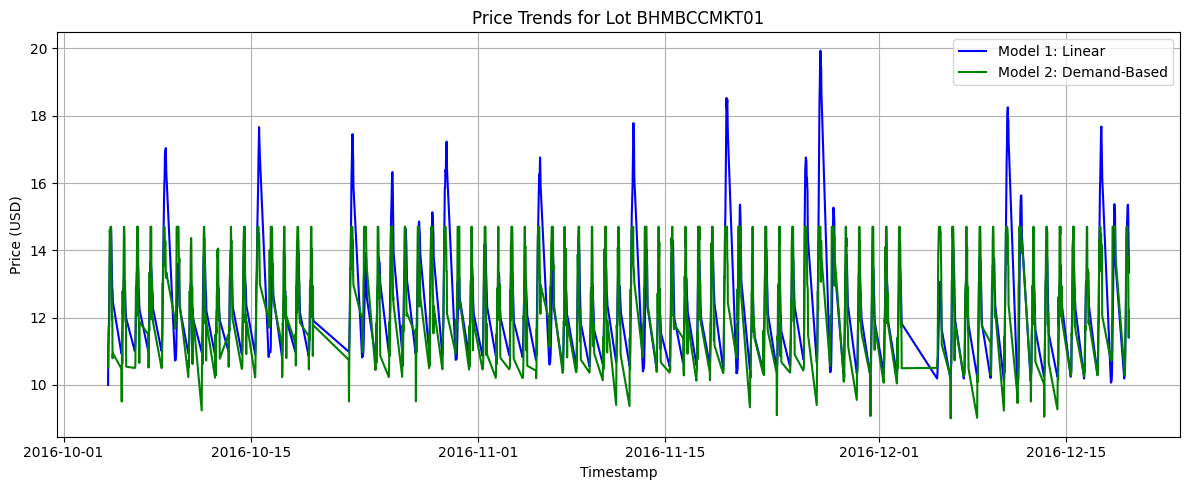

In [77]:
import matplotlib.pyplot as plt                 # For plotting the price trends
import ipywidgets as widgets                   # For creating interactive dropdown UI
from IPython.display import display, clear_output  # For updating output dynamically in notebook

# Convert 'SystemCodeNumber' to string to ensure consistency during filtering
df['SystemCodeNumber'] = df['SystemCodeNumber'].astype(str)

# Get sorted list of unique parking lot IDs for dropdown options
lot_options = sorted(df['SystemCodeNumber'].unique())

# Create a dropdown widget for selecting a parking lot
dropdown = widgets.Dropdown(options=lot_options, description='Select Lot:')

# Define a function to plot price trends for the selected parking lot
def plot_prices(change):
    lot_id = change['new']  # Get selected parking lot ID from dropdown

    clear_output(wait=True)   # Clear previous plot output
    display(dropdown)         # Redisplay the dropdown widget

    # Filter the DataFrame for the selected lot and sort by timestamp
    filtered = df[df['SystemCodeNumber'] == lot_id].sort_values('Timestamp')

    # Initialize the figure
    plt.figure(figsize=(12, 5))

    # Plot Model 1 (Linear Pricing)
    plt.plot(filtered['Timestamp'],
             filtered['price_model1'],
             label='Model 1: Linear',
             color='blue')

    # Plot Model 2 (Demand-Based Pricing) with a small visual offset
    plt.plot(filtered['Timestamp'],
             filtered['price_model2'] - 0.3,  # Offset for better visual separation
             label='Model 2: Demand-Based',
             color='green')

    # Add title, labels, and legend
    plt.title(f'Price Trends for Lot {lot_id}')
    plt.xlabel('Timestamp')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Bind the dropdown selection to the plotting function
dropdown.observe(plot_prices, names='value')

# Display the dropdown and show the initial plot for the first parking lot
display(dropdown)
plot_prices({'new': lot_options[0]})


In [78]:
%%capture --no-display
# Run the Pathway data pipeline (suppresses output display)
pw.run()

Output()

## 🧠 Conclusion

In this notebook, we implemented a dynamic pricing system for urban parking lots using both:
- **Model 1**: Linear pricing based on occupancy ratio
- **Model 2**: Demand-based pricing using queue length, traffic, vehicle type, and special days

We also:
- Processed streaming data using **Pathway**
- Applied a **daily tumbling window** to extract day-wise trends
- Built an **interactive visualization** to explore pricing behavior across different parking lots

🔍 The visual outputs show how pricing can fluctuate based on real-world factors, and how different models behave under changing conditions.  
This framework could be further extended with real-time inputs or predictive modeling for smart city applications.